In [52]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from helpers import combine_position_data
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import root_mean_squared_error, r2_score

In [20]:
data_directory = "Fantasy-Premier-League/data"
seasons = ["2022-23", "2023-24", "2024-25"]
positions = ["DEF", "MID", "FWD"]
output_file_name = "xg_training_data.csv"

combine_position_data(data_directory, seasons, positions, output_file_name)

Loaded data from DEF_players.csv for season 2022-23.
Loaded data from MID_players.csv for season 2022-23.
Loaded data from FWD_players.csv for season 2022-23.
Loaded data from DEF_players.csv for season 2023-24.
Loaded data from MID_players.csv for season 2023-24.
Loaded data from FWD_players.csv for season 2023-24.
Loaded data from DEF_players.csv for season 2024-25.
Loaded data from MID_players.csv for season 2024-25.
Loaded data from FWD_players.csv for season 2024-25.
Combined data saved to Fantasy-Premier-League/data/training_data/xg_training_data.csv.


In [54]:
data_directory = "Fantasy-Premier-League/data/training_data"
training_file = os.path.join(data_directory, "xg_training_data.csv")
data = pd.read_csv(training_file)

# Feature engineering
data['was_home'] = data['was_home'].astype(int)
data['home_crowd_effect'] = data['was_home'] * data['crowds']
data = data.sort_values(by=["unique_id", "season", "gameweek"])

data['rolling_xg_5'] = (
    data.groupby("unique_id")['expected_goals']
    .apply(lambda x: x.shift(1).rolling(window=5, min_periods=1).mean())
    .reset_index(level=0, drop=True)
)

data.fillna(0, inplace=True)

# One-hot encoding for categorical features
data = pd.get_dummies(data, columns=["POS", "season"], drop_first=True)

numerical_features = [
    "gameweek", "value", "home_crowd_effect", 
    "opponent_defense", "own_attack", "rolling_xg_5", "unique_id"
]
categorical_features = [col for col in data.columns if col.startswith("POS_") or col.startswith("season_")]
features = numerical_features + categorical_features
target = "expected_goals"

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")

cv_scores = cross_val_score(
    model,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
cv_rmse = -np.mean(cv_scores)
print(f"Cross-validated RMSE: {cv_rmse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

models_folder = "models"
os.makedirs(models_folder, exist_ok=True)
model_path = os.path.join(models_folder, "xgboost_xg_prediction_model.json")
model.save_model(model_path)
print(f"Model saved at: {model_path}")

RMSE: 0.1427868672439734
Cross-validated RMSE: 0.13543768337495773
R-squared: 0.23232492082623712
Model saved at: models/xgboost_xg_prediction_model.json


<Figure size 1000x800 with 0 Axes>

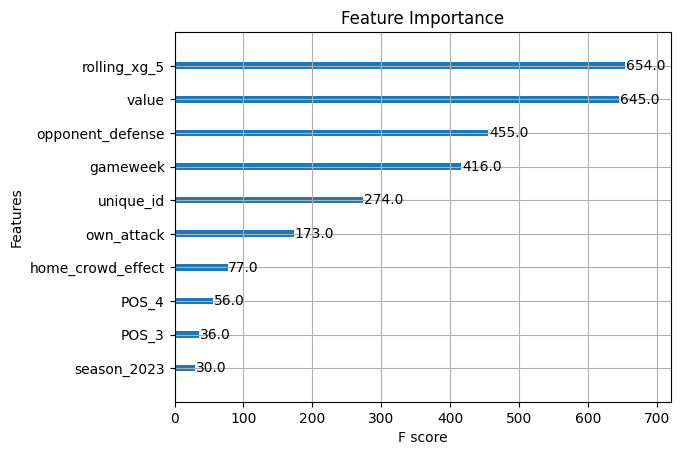

In [55]:
plt.figure(figsize=(10, 8))
plot_importance(model, max_num_features=10, importance_type="weight")
plt.title("Feature Importance")
plt.show()